In [1]:
import os
import random
import numpy as np
import math
import itertools
import ipaddress

SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.inception_v3 import InceptionV3

NETWORK = InceptionV3

# from kaggle_datasets import KaggleDatasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print("Tensorflow version ", tf.__version__)

Number of replicas: 1
Tensorflow version  2.10.0


In [3]:
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#user_credential = user_secrets.get_gcloud_credential()

#user_secrets.set_tensorflow_credential(user_credential)

In [4]:
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

Epochs = 1

dataset_id1 = 'covid19-lung-ct-scans'
# GCS_PATH1 = KaggleDatasets().get_gcs_path(dataset_id1)
GCS_PATH1 = '.'
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = [224, 224]
input_shape = (224, 224, 3)
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

Early_Stop = 15
OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-2, decay = 1e-5)

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

C:\Users\RenatoCiz\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
filenames = tf.io.gfile.glob(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/COVID-19/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/Non-COVID-19/*')))
#filenames.remove(str(GCS_PATH1 + '/COVID-19_Lung_CT_Scans/COVID-19/desktop.ini'))
    
random.shuffle(filenames)

In [7]:
COUNT_COVID = len([filename for filename in filenames if "\\COVID-19\\" in filename])
print("COVID-19 images count : " + str(COUNT_COVID))

COUNT_Non_COVID = len([filename for filename in filenames if "\\Non-COVID-19\\" in filename])
print("Non-COVID images count : " + str(COUNT_Non_COVID))

COVID-19 images count : 100
Non-COVID images count : 100


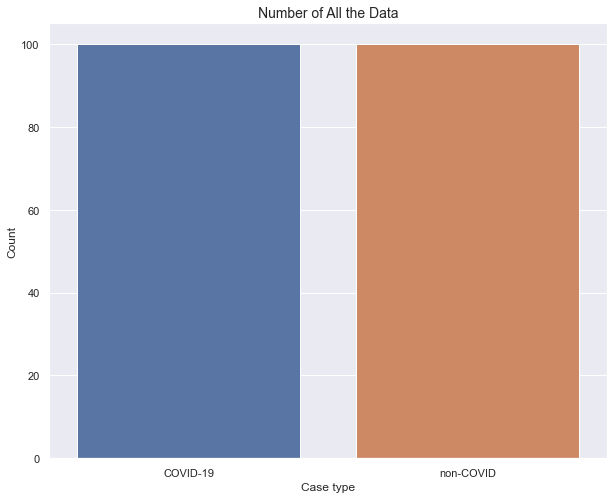

       Cases  Cases_count
0   COVID-19          100
1  non-COVID          100


In [8]:
data = {'Cases':['COVID-19', 'non-COVID'],
        'Cases_count':[COUNT_COVID, COUNT_Non_COVID]
       }

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x=df.index, y= df['Cases_count'].values)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(df.index)), ['COVID-19', 'non-COVID'])
plt.show()

print(df)

In [9]:
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

In [10]:
print(len(train_filenames))

128


In [11]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Test_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Testing images count: " + str(Test_IMG_COUNT))

Training images count: 128
Validating images count: 32
Testing images count: 40


In [79]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    print(int(parts[1] == CLASSES))
    return int(parts[1] == CLASSES)

In [80]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [81]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [83]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("Cast:0", shape=(2,), dtype=int32)
Tensor("Cast:0", shape=(2,), dtype=int32)
Tensor("Cast:0", shape=(2,), dtype=int32)


In [ ]:
def prepare_for_training(ds, cache=True):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)

    if cache:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [18]:
img_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomContrast(factor=0.20)
    ],name="Augmentation")

In [35]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(1,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[np.argmax(label_batch[n])])
        plt.axis("off")

IndexError: index 2 is out of bounds for axis 0 with size 2

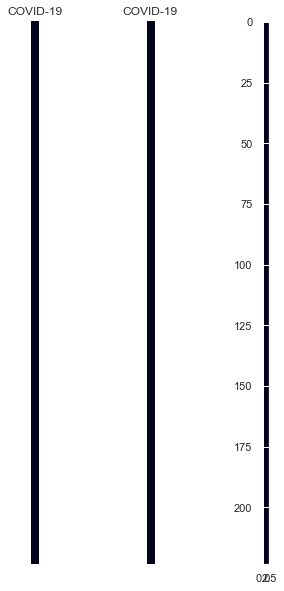

In [36]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels

x_test, y_test = dataset_to_numpy_util(test_ds, Test_IMG_COUNT)

print("Evaluation Dataset:")
print('X shape: ', x_test.shape,' Y shape: ', y_test.shape)